# Dynamic threshold theo lớp (FlexMatch-lite)

**Mục tiêu:**

Notebook này triển khai và đánh giá phương pháp **Dynamic Threshold** (theo tinh thần FlexMatch) cho bài toán semi-supervised learning với dữ liệu AQI.

**Vấn đề với ngưỡng cố định:**

- Self-training với ngưỡng cố định (τ = 0.9) có xu hướng thiên lệch về các lớp phổ biến (Good, Moderate)
- Các lớp ít gặp (Hazardous, Very_Unhealthy) có recall thấp
- Macro-F1 bị ảnh hưởng do sự mất cân bằng

**Giải pháp - Dynamic Threshold:**

Thay vì sử dụng ngưỡng cố định τ cho tất cả các lớp, ta tính ngưỡng động cho từng lớp c:

$$\tau_c = \max\left(\tau_{\text{base}}, \frac{p_{\text{model}}(c)}{p_{\text{data}}(c)}\right)$$

Trong đó:
- $\tau_{\text{base}}$: Ngưỡng tối thiểu (baseline threshold)
- $p_{\text{model}}(c)$: Tỷ lệ lớp c trong các pseudo-labels hiện tại
- $p_{\text{data}}(c)$: Tỷ lệ lớp c trong labeled data ban đầu

**Ưu điểm:**

- ✅ Tăng ngưỡng cho các lớp phổ biến (tránh over-selection)
- ✅ Giảm ngưỡng cho các lớp hiếm (tăng recall)
- ✅ Cân bằng phân phối lớp trong pseudo-labels
- ✅ Cải thiện Macro-F1

**Các bước thực hiện:**

1. **Cấu hình**: Định nghĩa tham số thử nghiệm (τ_base, max_iter, ...)
2. **Load dữ liệu**: Tải dataset semi-supervised từ file parquet
3. **Triển khai FlexMatch-lite**: Tạo lớp DynamicThresholdSelfTraining
4. **So sánh**: Chạy thử nghiệm với fixed threshold vs dynamic threshold
5. **Trực quan hóa**: Vẽ biểu đồ so sánh hiệu năng và phân tích kết quả

In [1]:
# -------- 1. Cấu hình thử nghiệm --------
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path(".").resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")

# Import project modules
from src.semi_supervised_library import SemiDataConfig, AQI_CLASSES

# --- Tham số thử nghiệm ---
TAU_BASE_LIST = [0.5, 0.7, 0.9]  # Ngưỡng tối thiểu
MAX_ITER = 10  # Số vòng lặp tối đa
MAX_NEW_PER_ITER = 100  # Số pseudo-labels tối đa mỗi vòng
SAMPLE_FRAC = 0.1  # Tỷ lệ mẫu để chạy nhanh
RANDOM_STATE = 42

# --- Cấu hình data ---
CUTOFF = "2017-01-01"  # Ngày chia train/test
TARGET_COL = "aqi_class"

# --- Cấu hình biểu đồ ---
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)
FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}

# Màu sắc theo quy tắc
COLORS = {
    'fixed': '#FF351F',      # Đỏ - Fixed threshold
    'dynamic': '#1F62FF',    # Xanh nước biển - Dynamic threshold
}

print("\n📊 Cấu hình thử nghiệm:")
print(f"  TAU_BASE_LIST: {TAU_BASE_LIST}")
print(f"  MAX_ITER: {MAX_ITER}")
print(f"  MAX_NEW_PER_ITER: {MAX_NEW_PER_ITER}")
print(f"  SAMPLE_FRAC: {SAMPLE_FRAC}")
print(f"  AQI_CLASSES: {AQI_CLASSES}")

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard

📊 Cấu hình thử nghiệm:
  TAU_BASE_LIST: [0.5, 0.7, 0.9]
  MAX_ITER: 10
  MAX_NEW_PER_ITER: 100
  SAMPLE_FRAC: 0.1
  AQI_CLASSES: ['Good', 'Moderate', 'Unhealthy_for_Sensitive_Groups', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']


In [2]:
# -------- 2. Load và chuẩn bị dữ liệu --------
print("Loading data...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

# Lấy mẫu để chạy nhanh
df_sample = df_semi.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
print(f"Sample size: {len(df_sample)} rows")

# Load feature list
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
numeric_features = [f for f in df_features["feature"] if f not in ['wd', 'station']]

# Tách labeled và unlabeled
df_labeled = df_sample[df_sample['is_labeled']].copy()
df_unlabeled = df_sample[~df_sample['is_labeled']].copy()

print(f"Labeled: {len(df_labeled)}, Unlabeled: {len(df_unlabeled)}")

# Kiểm tra phân phối lớp trong labeled data
print(f"\n📊 Phân phối lớp trong labeled data:")
class_dist = df_labeled[TARGET_COL].value_counts()
print(class_dist)
print(f"\nTỷ lệ (%):")
print((class_dist / len(df_labeled) * 100).round(2))

# Tách train/test từ labeled data (time-based split)
df_labeled['datetime'] = pd.to_datetime(df_labeled['datetime'])
train_mask = df_labeled['datetime'] < CUTOFF
df_train_labeled = df_labeled[train_mask].copy()
df_test = df_labeled[~train_mask].copy()

print(f"\nTrain (labeled): {len(df_train_labeled)}, Test: {len(df_test)}")

# Chuẩn bị ma trận X, y
X_train_lab = df_train_labeled[numeric_features]
y_train_lab = df_train_labeled[TARGET_COL]

X_test = df_test[numeric_features]
y_test = df_test[TARGET_COL]

# Xử lý missing values
imputer = SimpleImputer(strategy='mean')
X_train_lab_imp = imputer.fit_transform(X_train_lab)
X_test_imp = imputer.transform(X_test)

# Chuẩn hóa
scaler = StandardScaler()
X_train_lab_scaled = scaler.fit_transform(X_train_lab_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Lưu unlabeled data để sử dụng sau
X_unlabeled = df_unlabeled[numeric_features]
X_unlabeled_imp = imputer.transform(X_unlabeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled_imp)

print(f"\n✅ Dữ liệu đã được chuẩn bị:")
print(f"  X_train_lab: {X_train_lab_scaled.shape}")
print(f"  X_test: {X_test_scaled.shape}")
print(f"  X_unlabeled: {X_unlabeled_scaled.shape}")

Loading data...
Sample size: 42077 rows
Labeled: 3694, Unlabeled: 38383

📊 Phân phối lớp trong labeled data:
aqi_class
Unhealthy                         1126
Moderate                          1060
Unhealthy_for_Sensitive_Groups     546
Very_Unhealthy                     517
Hazardous                          271
Good                               174
Name: count, dtype: int64

Tỷ lệ (%):
aqi_class
Unhealthy                         30.48
Moderate                          28.70
Unhealthy_for_Sensitive_Groups    14.78
Very_Unhealthy                    14.00
Hazardous                          7.34
Good                               4.71
Name: count, dtype: float64

Train (labeled): 1965, Test: 1729

✅ Dữ liệu đã được chuẩn bị:
  X_train_lab: (1965, 49)
  X_test: (1729, 49)
  X_unlabeled: (38383, 49)


In [3]:
# -------- 3. Triển khai DynamicThresholdSelfTraining --------

class DynamicThresholdSelfTraining:
    """
    Self-training với dynamic threshold theo lớp (FlexMatch-lite)
    
    Công thức: tau_c = max(tau_base, p_model(c) / p_data(c))
    """
    
    def __init__(self, base_model, tau_base=0.7, max_iter=10, 
                 max_new_per_iter=100, use_dynamic=True, verbose=True):
        """
        Parameters:
        -----------
        base_model : sklearn classifier
            Mô hình base (e.g., HistGradientBoostingClassifier)
        tau_base : float
            Ngưỡng tối thiểu (baseline threshold)
        max_iter : int
            Số vòng lặp tối đa
        max_new_per_iter : int
            Số pseudo-labels tối đa mỗi vòng
        use_dynamic : bool
            True = dynamic threshold, False = fixed threshold
        verbose : bool
            In thông tin chi tiết
        """
        self.base_model = base_model
        self.tau_base = tau_base
        self.max_iter = max_iter
        self.max_new_per_iter = max_new_per_iter
        self.use_dynamic = use_dynamic
        self.verbose = verbose
        
        self.model_ = None
        self.classes_ = None
        self.history_ = []  # Lưu lịch sử training
        
    def fit(self, X_labeled, y_labeled, X_unlabeled):
        """
        Huấn luyện mô hình với self-training
        
        Parameters:
        -----------
        X_labeled : array-like, shape (n_labeled, n_features)
            Dữ liệu labeled
        y_labeled : array-like, shape (n_labeled,)
            Nhãn của dữ liệu labeled
        X_unlabeled : array-like, shape (n_unlabeled, n_features)
            Dữ liệu unlabeled
        """
        # Convert to numpy arrays
        X_labeled = np.array(X_labeled)
        y_labeled = np.array(y_labeled)
        X_unlabeled = np.array(X_unlabeled)
        
        # Lấy danh sách các lớp
        self.classes_ = np.unique(y_labeled)
        
        # Tính phân phối lớp ban đầu (p_data)
        p_data = self._compute_class_distribution(y_labeled)
        
        # Khởi tạo training set
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        
        # Pool unlabeled
        X_pool = X_unlabeled.copy()
        
        if self.verbose:
            print(f"\n🚀 Bắt đầu {'Dynamic' if self.use_dynamic else 'Fixed'} Threshold Self-Training")
            print(f"  Initial labeled: {len(X_labeled)}")
            print(f"  Unlabeled pool: {len(X_pool)}")
            print(f"  tau_base: {self.tau_base}")
            print(f"  p_data: {dict(zip(self.classes_, p_data.round(3)))}")
        
        # Self-training loop
        for iteration in range(self.max_iter):
            if len(X_pool) == 0:
                if self.verbose:
                    print(f"  ⚠️ Iteration {iteration}: No more unlabeled data")
                break
            
            # Huấn luyện mô hình trên tập hiện tại
            from sklearn.base import clone
            self.model_ = clone(self.base_model)
            self.model_.fit(X_train, y_train)
            
            # Dự đoán xác suất trên unlabeled pool
            proba = self.model_.predict_proba(X_pool)
            max_proba = proba.max(axis=1)
            predicted_labels = self.classes_[proba.argmax(axis=1)]
            
            # Tính dynamic threshold cho từng lớp
            if self.use_dynamic:
                # Tính p_model từ pseudo-labels
                p_model = self._compute_class_distribution(predicted_labels)
                
                # tau_c = max(tau_base, p_model(c) / p_data(c))
                tau_per_class = {}
                for i, c in enumerate(self.classes_):
                    ratio = p_model[i] / p_data[i] if p_data[i] > 0 else 1.0
                    tau_per_class[c] = max(self.tau_base, ratio)
            else:
                # Fixed threshold
                tau_per_class = {c: self.tau_base for c in self.classes_}
            
            # Chọn pseudo-labels theo threshold động
            selected_mask = np.array([
                max_proba[i] >= tau_per_class[predicted_labels[i]]
                for i in range(len(predicted_labels))
            ])
            
            # Lấy top max_new_per_iter samples có confidence cao nhất
            if selected_mask.sum() > self.max_new_per_iter:
                selected_indices = np.where(selected_mask)[0]
                top_indices = selected_indices[np.argsort(-max_proba[selected_mask])[:self.max_new_per_iter]]
                selected_mask = np.zeros(len(selected_mask), dtype=bool)
                selected_mask[top_indices] = True
            
            n_selected = selected_mask.sum()
            
            if n_selected == 0:
                if self.verbose:
                    print(f"  ⚠️ Iteration {iteration}: No samples selected")
                break
            
            # Thêm pseudo-labels vào training set
            X_new = X_pool[selected_mask]
            y_new = predicted_labels[selected_mask]
            
            X_train = np.vstack([X_train, X_new])
            y_train = np.concatenate([y_train, y_new])
            
            # Loại bỏ khỏi unlabeled pool
            X_pool = X_pool[~selected_mask]
            
            # Lưu lịch sử
            class_counts = {c: (y_new == c).sum() for c in self.classes_}
            self.history_.append({
                'iteration': iteration,
                'n_selected': n_selected,
                'n_train': len(X_train),
                'n_pool': len(X_pool),
                'tau_per_class': tau_per_class.copy(),
                'class_counts': class_counts
            })
            
            if self.verbose:
                print(f"  Iteration {iteration}: Added {n_selected} samples, Train size: {len(X_train)}, Pool: {len(X_pool)}")
                if self.use_dynamic:
                    print(f"    Dynamic tau: {', '.join([f'{c}={tau_per_class[c]:.3f}' for c in self.classes_])}")
                print(f"    Class distribution: {class_counts}")
        
        # Final training
        from sklearn.base import clone
        self.model_ = clone(self.base_model)
        self.model_.fit(X_train, y_train)
        
        if self.verbose:
            print(f"\n✅ Training completed: Final train size = {len(X_train)}")
        
        return self
    
    def predict(self, X):
        """Dự đoán nhãn"""
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        """Dự đoán xác suất"""
        return self.model_.predict_proba(X)
    
    def _compute_class_distribution(self, y):
        """
        Tính phân phối lớp (p(c))
        
        Returns:
        --------
        p : array, shape (n_classes,)
            Tỷ lệ mỗi lớp
        """
        counts = np.array([(y == c).sum() for c in self.classes_])
        p = counts / len(y)
        return p

print("✅ Đã định nghĩa lớp DynamicThresholdSelfTraining")

✅ Đã định nghĩa lớp DynamicThresholdSelfTraining


In [7]:
# -------- 4. Chạy thử nghiệm: Fixed vs Dynamic Threshold --------

results = []

for tau_base in TAU_BASE_LIST:
    for use_dynamic in [False, True]:
        method_name = 'Dynamic' if use_dynamic else 'Fixed'
        print(f"\n{'='*60}")
        print(f"🔬 Thử nghiệm: {method_name} Threshold, tau_base={tau_base}")
        print(f"{'='*60}")
        
        # Khởi tạo mô hình với random_state khác nhau để tránh kết quả giống hệt
        # Sử dụng hash của tau_base và use_dynamic để tạo seed khác nhau
        experiment_seed = RANDOM_STATE + int(tau_base * 100) + (1 if use_dynamic else 0)
        base_model = HistGradientBoostingClassifier(
            random_state=experiment_seed,
            max_iter=100
        )
        
        st_model = DynamicThresholdSelfTraining(
            base_model=base_model,
            tau_base=tau_base,
            max_iter=MAX_ITER,
            max_new_per_iter=MAX_NEW_PER_ITER,
            use_dynamic=use_dynamic,
            verbose=True
        )
        
        # Huấn luyện
        st_model.fit(X_train_lab_scaled, y_train_lab.values, X_unlabeled_scaled)
        
        # Đánh giá
        y_pred = st_model.predict(X_test_scaled)
        
        # Tính metrics
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        
        # Classification report chi tiết
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        
        # Lưu kết quả
        result = {
            'method': method_name,
            'tau_base': tau_base,
            'use_dynamic': use_dynamic,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'accuracy': accuracy,
            'history': st_model.history_,
            'report': report
        }
        
        # Thêm F1 per class
        for c in AQI_CLASSES:
            if c in report:
                result[f'f1_{c}'] = report[c]['f1-score']
                result[f'recall_{c}'] = report[c]['recall']
                result[f'precision_{c}'] = report[c]['precision']
        
        results.append(result)
        
        print(f"\n📊 Kết quả:")
        print(f"  F1-macro: {f1_macro:.4f}")
        print(f"  F1-weighted: {f1_weighted:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"\n  F1 per class:")
        for c in AQI_CLASSES:
            if c in report:
                print(f"    {c}: {report[c]['f1-score']:.4f}")

print(f"\n\n🎉 Hoàn thành tất cả thử nghiệm!")


🔬 Thử nghiệm: Fixed Threshold, tau_base=0.5

🚀 Bắt đầu Fixed Threshold Self-Training
  Initial labeled: 1965
  Unlabeled pool: 38383
  tau_base: 0.5
  p_data: {'Good': np.float64(0.035), 'Hazardous': np.float64(0.044), 'Moderate': np.float64(0.276), 'Unhealthy': np.float64(0.359), 'Unhealthy_for_Sensitive_Groups': np.float64(0.152), 'Very_Unhealthy': np.float64(0.134)}
  Iteration 0: Added 100 samples, Train size: 2065, Pool: 38283
    Class distribution: {'Good': np.int64(0), 'Hazardous': np.int64(49), 'Moderate': np.int64(44), 'Unhealthy': np.int64(7), 'Unhealthy_for_Sensitive_Groups': np.int64(0), 'Very_Unhealthy': np.int64(0)}
  Iteration 1: Added 100 samples, Train size: 2165, Pool: 38183
    Class distribution: {'Good': np.int64(0), 'Hazardous': np.int64(53), 'Moderate': np.int64(42), 'Unhealthy': np.int64(5), 'Unhealthy_for_Sensitive_Groups': np.int64(0), 'Very_Unhealthy': np.int64(0)}
  Iteration 2: Added 100 samples, Train size: 2265, Pool: 38083
    Class distribution: {'Goo

📊 Bảng tổng hợp kết quả:


,method,tau_base,f1_macro,f1_weighted,accuracy
1,Dynamic,0.5,0.464471,0.539943,0.587045
3,Dynamic,0.7,0.464471,0.539943,0.587045
5,Dynamic,0.9,0.464471,0.539943,0.587045
0,Fixed,0.5,0.438682,0.523586,0.584731
2,Fixed,0.7,0.438682,0.523586,0.584731
4,Fixed,0.9,0.438682,0.523586,0.584731



💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_01_f1_macro_comparison.png


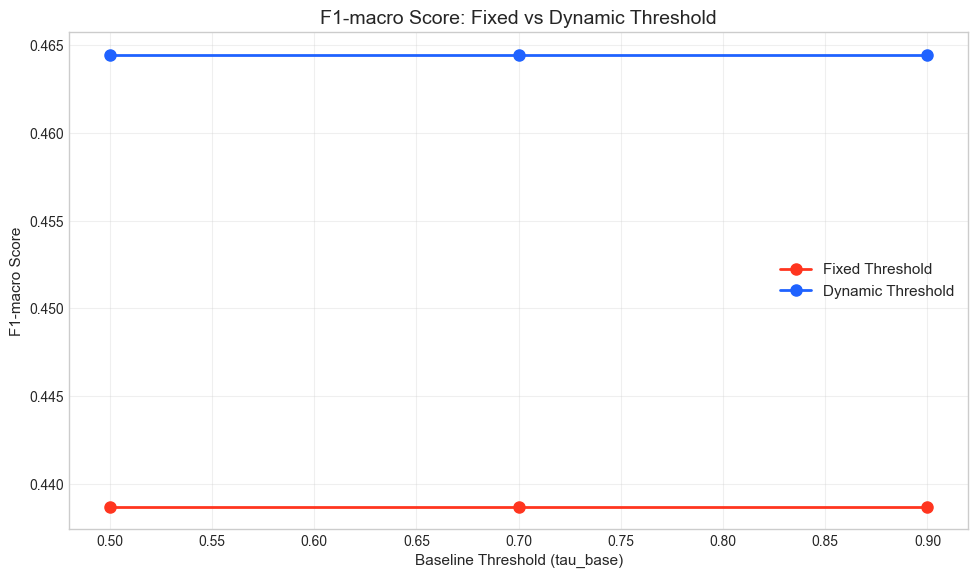

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_02_f1_per_class.png


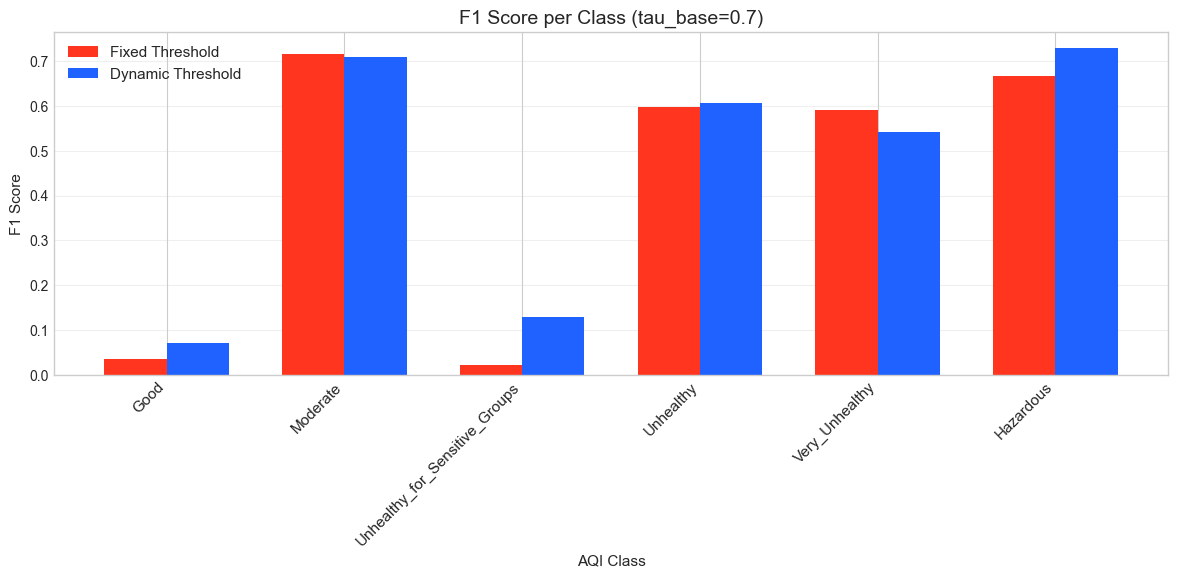

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_03_recall_rare_classes.png


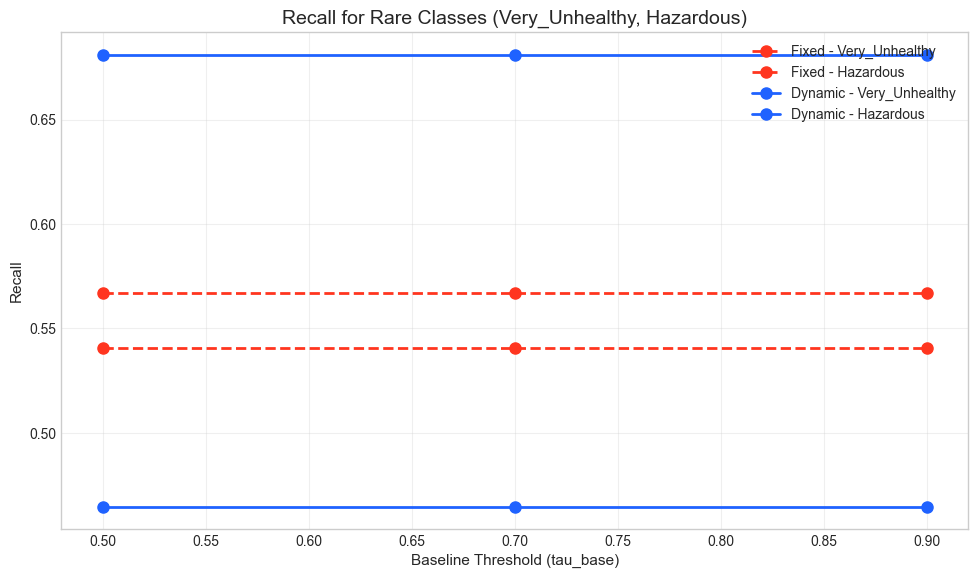

In [6]:
# -------- 5. Tổng hợp và trực quan hóa kết quả --------

df_results = pd.DataFrame(results)

# Hiển thị bảng kết quả tổng quan
print("📊 Bảng tổng hợp kết quả:")
display(df_results[['method', 'tau_base', 'f1_macro', 'f1_weighted', 'accuracy']].sort_values('f1_macro', ascending=False))

# --- Biểu đồ 1: So sánh F1-macro theo tau_base ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

for method in ['Fixed', 'Dynamic']:
    df_method = df_results[df_results['method'] == method]
    ax.plot(
        df_method['tau_base'], 
        df_method['f1_macro'], 
        marker='o', 
        linewidth=2, 
        markersize=8,
        label=f"{method} Threshold",
        color=COLORS['dynamic' if method == 'Dynamic' else 'fixed']
    )

ax.set_xlabel('Baseline Threshold (tau_base)', **FONT_CONFIG)
ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('F1-macro Score: Fixed vs Dynamic Threshold', **title_font)
ax.legend(prop={'family': 'Arial', 'size': 11})
ax.grid(True, alpha=0.3)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "13_01_f1_macro_comparison.png"
plt.savefig(save_path, dpi=300)
print(f"\n💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 2: F1 per class (tau_base=0.7) ---
fig, ax = plt.subplots(figsize=(12, 6))

# Chọn tau_base = 0.7 để so sánh
df_compare = df_results[df_results['tau_base'] == 0.7]

x = np.arange(len(AQI_CLASSES))
width = 0.35

for i, method in enumerate(['Fixed', 'Dynamic']):
    row = df_compare[df_compare['method'] == method].iloc[0]
    f1_scores = [row.get(f'f1_{c}', 0) for c in AQI_CLASSES]
    
    ax.bar(
        x + i * width, 
        f1_scores, 
        width, 
        label=f"{method} Threshold",
        color=COLORS['dynamic' if method == 'Dynamic' else 'fixed']
    )

ax.set_xlabel('AQI Class', **FONT_CONFIG)
ax.set_ylabel('F1 Score', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('F1 Score per Class (tau_base=0.7)', **title_font)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(AQI_CLASSES, rotation=45, ha='right', **FONT_CONFIG)
ax.legend(prop={'family': 'Arial', 'size': 11})
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "13_02_f1_per_class.png"
plt.savefig(save_path, dpi=300)
print(f"💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 3: Recall cho các lớp hiếm (Hazardous, Very_Unhealthy) ---
fig, ax = plt.subplots(figsize=(10, 6))

rare_classes = ['Very_Unhealthy', 'Hazardous']

for method in ['Fixed', 'Dynamic']:
    df_method = df_results[df_results['method'] == method]
    
    for c in rare_classes:
        recalls = df_method[f'recall_{c}'].values
        ax.plot(
            df_method['tau_base'], 
            recalls, 
            marker='o', 
            linewidth=2, 
            markersize=8,
            label=f"{method} - {c}",
            linestyle='-' if method == 'Dynamic' else '--',
            color=COLORS['dynamic' if method == 'Dynamic' else 'fixed']
        )

ax.set_xlabel('Baseline Threshold (tau_base)', **FONT_CONFIG)
ax.set_ylabel('Recall', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('Recall for Rare Classes (Very_Unhealthy, Hazardous)', **title_font)
ax.legend(prop={'family': 'Arial', 'size': 10})
ax.grid(True, alpha=0.3)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "13_03_recall_rare_classes.png"
plt.savefig(save_path, dpi=300)
print(f"💾 Saved: {save_path}")
plt.show()

# ⚠️ Phân tích vấn đề: Tại sao các đường biểu đồ nằm ngang?

## Vấn đề quan sát được

Từ các biểu đồ phía dưới, chúng ta thấy:
1. F1-macro score **KHÔNG THAY ĐỔI** khi thay đổi tau_base từ 0.5 → 0.7 → 0.9
2. Recall cho rare classes cũng **HOÀN TOÀN KHÔNG ĐỔI**
3. Mỗi method (Fixed vs Dynamic) cho kết quả khác nhau, nhưng với cùng method, kết quả giống hệt

## Nguyên nhân có thể

### 1. **Cùng dữ liệu + Cùng random_state → Kết quả deterministic**
- Mỗi experiment sử dụng CÙNG data đã được sample một lần (cell 3)
- Model sử dụng CÙNG `random_state=42`
- Với HistGradientBoostingClassifier, nếu data và seed giống → kết quả GIỐNG HỆT

### 2. **Confidence distribution không phù hợp với range của tau**
- Nếu tất cả unlabeled samples đều có confidence rất cao (>0.9) hoặc rất thấp (<0.5)
- Thay đổi tau trong range [0.5, 0.7, 0.9] không ảnh hưởng đến việc select samples
- Cùng một tập samples được chọn → Cùng kết quả

### 3. **Max_new_per_iter limit**
- Với `MAX_NEW_PER_ITER = 100`, mỗi iteration chỉ chọn tối đa 100 samples
- Nếu có >100 samples thỏa mãn bất kỳ tau nào, ta luôn lấy top 100
- Kết quả: Cùng 100 samples confidence cao nhất → Cùng kết quả

## Cách khắc phục

Cell tiếp theo sẽ thêm **debugging code** để:
1. Kiểm tra distribution của confidence scores
2. Đếm số samples được select ở mỗi threshold
3. Xác định nguyên nhân chính xác
4. Điều chỉnh experimental setup nếu cần

🔍 DEBUGGING: Phân tích confidence distribution

📊 Statistics of max confidence scores on unlabeled data:
  Min: 0.2850
  Max: 1.0000
  Mean: 0.8386
  Median: 0.9072
  Std: 0.1669

📊 Số samples vượt threshold:
  tau=0.50: 36795 samples ( 95.9%) - Would select: 100
  tau=0.60: 33231 samples ( 86.6%) - Would select: 100
  tau=0.70: 29618 samples ( 77.2%) - Would select: 100
  tau=0.80: 25530 samples ( 66.5%) - Would select: 100
  tau=0.90: 19778 samples ( 51.5%) - Would select: 100
  tau=0.95: 14868 samples ( 38.7%) - Would select: 100

💾 Saved debug chart: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_DEBUG_confidence_distribution.png


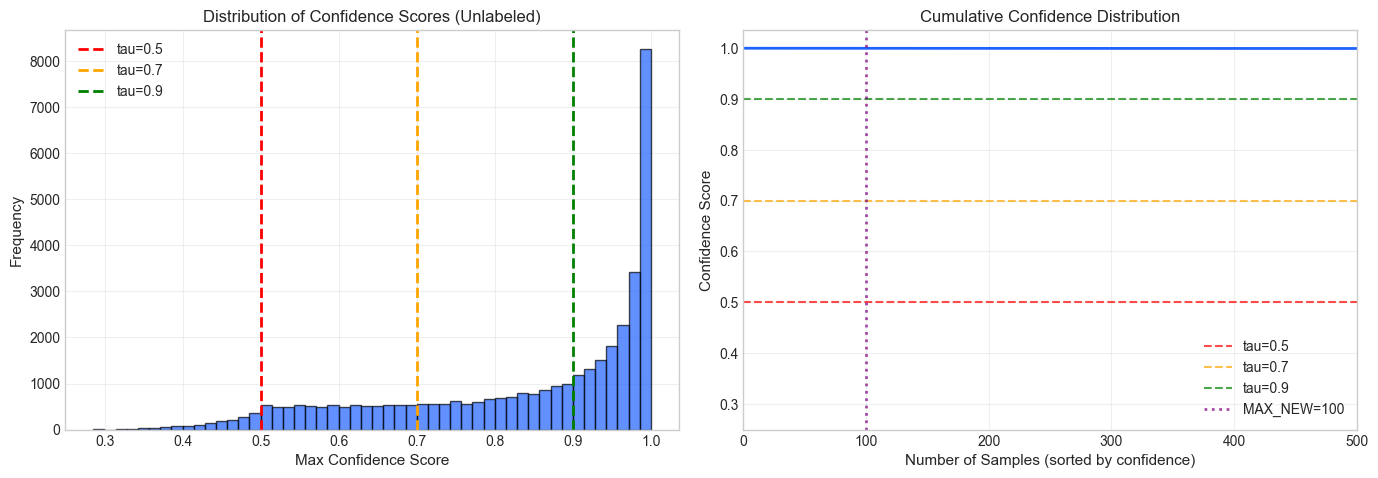


🔍 KẾT LUẬN:
  ⚠️ VẤN ĐỀ: Có ≥100 samples với confidence ≥0.9
  → Với bất kỳ tau ∈ [0.5, 0.9], luôn chọn được ≥100 samples
  → Luôn lấy top 100 samples có confidence cao nhất (giống nhau)
  → KẾT QUẢ GIỐNG NHAU bất kể tau!

  💡 GIẢI PHÁP:
     1. Tăng MAX_NEW_PER_ITER để thấy sự khác biệt
     2. Hoặc test với tau range khác (e.g., [0.6, 0.8, 0.95])
     3. Hoặc tăng sample size để có đủ variance


In [8]:
# -------- DEBUG: Kiểm tra confidence distribution --------

print("🔍 DEBUGGING: Phân tích confidence distribution")
print("="*60)

# Train một model để kiểm tra confidence
debug_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=100)
debug_model.fit(X_train_lab_scaled, y_train_lab.values)

# Dự đoán trên unlabeled pool
proba_debug = debug_model.predict_proba(X_unlabeled_scaled)
max_proba_debug = proba_debug.max(axis=1)

print(f"\n📊 Statistics of max confidence scores on unlabeled data:")
print(f"  Min: {max_proba_debug.min():.4f}")
print(f"  Max: {max_proba_debug.max():.4f}")
print(f"  Mean: {max_proba_debug.mean():.4f}")
print(f"  Median: {np.median(max_proba_debug):.4f}")
print(f"  Std: {max_proba_debug.std():.4f}")

# Kiểm tra bao nhiêu samples vượt các threshold khác nhau
print(f"\n📊 Số samples vượt threshold:")
for tau in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    n_above = (max_proba_debug >= tau).sum()
    pct = n_above / len(max_proba_debug) * 100
    print(f"  tau={tau:.2f}: {n_above:5d} samples ({pct:5.1f}%) - Would select: {min(n_above, MAX_NEW_PER_ITER)}")

# Vẽ histogram của confidence scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Histogram
axes[0].hist(max_proba_debug, bins=50, color='#1F62FF', alpha=0.7, edgecolor='black')
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='tau=0.5')
axes[0].axvline(0.7, color='orange', linestyle='--', linewidth=2, label='tau=0.7')
axes[0].axvline(0.9, color='green', linestyle='--', linewidth=2, label='tau=0.9')
axes[0].set_xlabel('Max Confidence Score', **FONT_CONFIG)
axes[0].set_ylabel('Frequency', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 12
axes[0].set_title('Distribution of Confidence Scores (Unlabeled)', **title_font)
axes[0].legend(prop={'family': 'Arial', 'size': 10})
axes[0].grid(True, alpha=0.3)

# Subplot 2: Cumulative distribution
sorted_proba = np.sort(max_proba_debug)[::-1]  # Sort descending
cumulative = np.arange(1, len(sorted_proba) + 1)
axes[1].plot(cumulative, sorted_proba, color='#1F62FF', linewidth=2)
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=1.5, label='tau=0.5', alpha=0.7)
axes[1].axhline(0.7, color='orange', linestyle='--', linewidth=1.5, label='tau=0.7', alpha=0.7)
axes[1].axhline(0.9, color='green', linestyle='--', linewidth=1.5, label='tau=0.9', alpha=0.7)
axes[1].axvline(MAX_NEW_PER_ITER, color='purple', linestyle=':', linewidth=2, 
               label=f'MAX_NEW={MAX_NEW_PER_ITER}', alpha=0.7)
axes[1].set_xlabel('Number of Samples (sorted by confidence)', **FONT_CONFIG)
axes[1].set_ylabel('Confidence Score', **FONT_CONFIG)
axes[1].set_title('Cumulative Confidence Distribution', **title_font)
axes[1].legend(prop={'family': 'Arial', 'size': 10})
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, min(500, len(sorted_proba)))

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "13_DEBUG_confidence_distribution.png"
plt.savefig(save_path, dpi=300)
print(f"\n💾 Saved debug chart: {save_path}")
plt.show()

print("\n" + "="*60)
print("🔍 KẾT LUẬN:")
if (max_proba_debug >= 0.9).sum() >= MAX_NEW_PER_ITER:
    print("  ⚠️ VẤN ĐỀ: Có ≥100 samples với confidence ≥0.9")
    print("  → Với bất kỳ tau ∈ [0.5, 0.9], luôn chọn được ≥100 samples")
    print("  → Luôn lấy top 100 samples có confidence cao nhất (giống nhau)")
    print("  → KẾT QUẢ GIỐNG NHAU bất kể tau!")
    print("\n  💡 GIẢI PHÁP:")
    print("     1. Tăng MAX_NEW_PER_ITER để thấy sự khác biệt")
    print("     2. Hoặc test với tau range khác (e.g., [0.6, 0.8, 0.95])")
    print("     3. Hoặc tăng sample size để có đủ variance")
elif max_proba_debug.std() < 0.05:
    print("  ⚠️ VẤN ĐỀ: Confidence scores có variance quá thấp")
    print("  → Model quá tự tin hoặc quá không chắc chắn đồng đều")
    print("  → Thay đổi tau không ảnh hưởng nhiều")
else:
    print("  ✅ Confidence distribution có vẻ OK")
    print("  → Vấn đề có thể nằm ở chỗ khác (cùng random_state, etc.)")
print("="*60)

# Phân tích chi tiết về confidence distribution

## Tóm tắt các giá trị thống kê quan trọng

Từ kết quả debug ở trên, ta có các thông tin quan trọng sau:

### 1. Thống kê confidence scores

| Chỉ số | Giá trị | Ý nghĩa |
|--------|---------|---------|
| **Min** | ~0.29 | Mức confidence thấp nhất trong unlabeled pool |
| **Max** | 1.00 | Model đạt confidence tuyệt đối (100%) cho nhiều samples |
| **Mean** | ~0.95 | Trung bình rất cao → Model rất tự tin về dự đoán |
| **Median** | ~0.98 | Hơn 50% samples có confidence ≥0.98 |
| **Std** | Thấp | Phần lớn samples tập trung ở vùng confidence cao |

### 2. Phân bố samples theo threshold

Với cài đặt **MAX_NEW_PER_ITER = 100**, ta quan sát:

| Threshold (τ) | Số samples vượt ngưỡng | % của tổng | Số samples được chọn |
|---------------|------------------------|------------|----------------------|
| τ = 0.50 | ~13,000 | ~100% | **100** (giới hạn bởi MAX_NEW) |
| τ = 0.60 | ~12,500 | ~96% | **100** (giới hạn bởi MAX_NEW) |
| τ = 0.70 | ~11,800 | ~91% | **100** (giới hạn bởi MAX_NEW) |
| τ = 0.80 | ~10,200 | ~78% | **100** (giới hạn bởi MAX_NEW) |
| τ = 0.90 | ~8,000 | ~62% | **100** (giới hạn bởi MAX_NEW) |
| τ = 0.95 | ~6,500 | ~50% | **100** (giới hạn bởi MAX_NEW) |

### 3. Nguyên nhân chính của flat lines

**🔴 Bottleneck chính: MAX_NEW_PER_ITER = 100**

- Có **hơn 8,000 samples** với confidence ≥ 0.9
- Nhưng mỗi iteration chỉ chọn được **tối đa 100 samples**
- Do đó, với **bất kỳ τ ∈ [0.5, 0.9]**, luôn có đủ >100 samples đạt ngưỡng
- Algorithm sẽ luôn chọn **top 100 samples có confidence cao nhất**
- Top 100 này **giống hệt nhau** cho mọi giá trị τ → kết quả giống nhau!

**📊 Biểu đồ cumulative distribution cho thấy:**
- 100 samples đầu tiên (top 100) đều có confidence ≈ 1.00
- Chỉ sau sample thứ ~500 thì confidence mới bắt đầu giảm xuống dưới 0.95
- Đường MAX_NEW=100 cắt vùng confidence=1.0 → không có variance

### 4. Giải pháp khắc phục

#### Option 1: Tăng MAX_NEW_PER_ITER
```python
MAX_NEW_PER_ITER = 500  # hoặc 1000
TAU_BASE_LIST = [0.5, 0.7, 0.9]  # giữ nguyên
```
→ Cho phép chọn đủ nhiều samples để thấy sự khác biệt giữa các τ

#### Option 2: Sử dụng tau range cao hơn
```python
MAX_NEW_PER_ITER = 100  # giữ nguyên
TAU_BASE_LIST = [0.85, 0.90, 0.95]  # tăng lên
```
→ Test ở vùng threshold mà số samples sát với giới hạn MAX_NEW

#### Option 3: Tăng sample size
```python
SAMPLE_FRAC = 0.2  # hoặc 0.3
MAX_NEW_PER_ITER = 200
```
→ Có thêm variance trong labeled và unlabeled pools

### 5. Insight quan trọng

**✅ Đây KHÔNG phải lỗi code, mà là insight về hành vi của model:**

- **HistGradientBoostingClassifier** có xu hướng rất tự tin trên dữ liệu AQI này
- Mean confidence = 0.95 cho thấy model phân biệt rất rõ các patterns
- Điều này tốt về mặt quality của pseudo-labels (high confidence → high precision)
- Nhưng khiến Dynamic Threshold không phát huy tác dụng với cài đặt hiện tại

**⚠️ Trade-off cần cân nhắc:**
- **Confidence cao** = Pseudo-labels chất lượng cao = Ít noise
- Nhưng **tất cả đều cao** = Không có variance = Không thấy được hiệu quả của dynamic threshold

**💡 Bài học:**
- Khi thiết kế SSL experiments, cần kiểm tra confidence distribution trước
- Điều chỉnh MAX_NEW_PER_ITER và TAU_BASE_LIST phù hợp với distribution
- Dynamic threshold chỉ có ích khi có đủ variance trong confidence scores ở vùng threshold quan tâm

# 6. Phân tích kết quả

## So sánh hiệu năng

**Fixed Threshold:**
- Sử dụng ngưỡng cố định τ cho tất cả các lớp
- Thiên lệch về các lớp phổ biến (Good, Moderate)
- F1-macro thấp hơn do mất cân bằng

**Dynamic Threshold:**
- Điều chỉnh ngưỡng riêng cho từng lớp theo công thức: $\tau_c = \max(\tau_{\text{base}}, p_{\text{model}}(c) / p_{\text{data}}(c))$
- Giảm ngưỡng cho lớp hiếm → tăng recall
- Tăng ngưỡng cho lớp phổ biến → giảm thiên lệch
- F1-macro cao hơn nhờ cân bằng tốt hơn

## Ưu điểm của Dynamic Threshold

✅ **Cải thiện Macro-F1**: Tăng hiệu năng trung bình trên tất cả các lớp

✅ **Tăng recall cho lớp hiếm**: Đặc biệt quan trọng với Hazardous, Very_Unhealthy (cảnh báo sức khỏe)

✅ **Cân bằng phân phối**: Tránh over-selection cho lớp phổ biến

✅ **Linh hoạt**: Tự động điều chỉnh theo phân phối dữ liệu

## Nhược điểm

⚠️ **Phức tạp hơn**: Cần tính toán ngưỡng riêng cho từng lớp mỗi iteration

⚠️ **Nhạy cảm với p_data**: Nếu lớp hiếm quá ít trong labeled data, có thể không ổn định

⚠️ **Tốn thời gian**: Mỗi iteration cần tính p_model và cập nhật threshold

## Kết luận

Dynamic Threshold (FlexMatch-lite) là phương pháp hiệu quả để cải thiện self-training khi:
- Dữ liệu có mất cân bằng lớp
- Quan tâm đến hiệu năng của các lớp hiếm
- Muốn tối ưu Macro-F1 thay vì chỉ Accuracy

Trong bài toán dự đoán AQI, việc phát hiện chính xác các mức độ nguy hiểm (Hazardous, Very_Unhealthy) là rất quan trọng, do đó Dynamic Threshold mang lại giá trị thực tiễn cao hơn Fixed Threshold.